In [113]:
import pandas as pd 
import numpy as np
import time
import re
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import LinearSVC,SVR
from sklearn.feature_selection import RFECV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import Binarizer
import matplotlib.pyplot as plt
from pylab import xticks, yticks
from sklearn.calibration import calibration_curve


In [114]:
import warnings
warnings.filterwarnings('ignore')

In [115]:
# some utils functions

## filter words from texts
def clean_words(text):
    res = re.findall(r'\b\w+\b', text)
    return res

## remove stopwords (some words are meaningless in classification, like function, test)
def remove_stopwords(text):
    text = str(text).lower().strip()
    tokens = []
    for token in text:
        if token not in stop_words:
            tokens.append(token)
            
    return "".join(tokens)

def remove_comments(text):
    no_comments = re.sub(r'#.*', '', text)
    no_comments = re.sub(r'/\*.*\/\*', '', no_comments)
    no_comments = re.sub(r'\d+','',no_comments)
    no_comments = re.sub(r'_', ' ', no_comments)
    return no_comments

def remove_cammel(text):
    no_cammel = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', text)).lower().split()
    return no_cammel

In [116]:

stop_words = ['main', 'new', 'subtest','mock','test','public','void','init', 'class', 'name', 'com', 'is', 'prepare',\
    'it', 'cn', 'com', 'runtests', 'testing', 'fuc','tests', 'atomic','ca','bs', 'dc','this', 'on', 'std', 'flaky', 'we',\
    'auto', 'it', 'to','def', 'self', 'base', 'left', 'hello', 'block', 'cli', 'all', 'from', 'import', 'id', 'result', \
    'run', 'cmd','mock','xd', 'yoda','country', 'class', 'out', 'this', 'on', 'std', 'flaky', 'we', 'auto','size', 'not', 'by', \
    'be','activejobs','back']

# describe the classifiers and parameters
classifiers = {
    'randomForest': RandomForestClassifier(random_state=1),
    'decisionTree': DecisionTreeClassifier(min_samples_leaf=1),
    'naiveBayes': GaussianNB(),
    'smo': CalibratedClassifierCV(LinearSVC(fit_intercept=False, tol=0.001, C=1, dual=False, max_iter=100000), method='sigmoid'),
    'knn': KNeighborsClassifier(n_neighbors=1, metric='euclidean'),
    'logisticRegression': LogisticRegression(max_iter=1000),
    'perceptron': CalibratedClassifierCV(Perceptron()),
    'lda': LinearDiscriminantAnalysis(),
}

## cross validation classification
def classify_with_cv(classifiers,x, y, random_state=123, cv = None, shuffle=True, normalize=[]):
    
    labels = ['Flaky', 'NonFlaky']
    results = pd.DataFrame()
    
    scaler = Binarizer(threshold=0.0,).fit(x)
    x_norm = scaler.transform(x)
    
    for key, classifier in classifiers.items():
        if (key in normalize):
            x = x_norm
         
        # classifier.fit(x_train, y_train)
        # classifier.score(x_test, y_test)
        score = cross_val_score(classifier, x, y, cv = cv, scoring='accuracy')
        predict = cross_val_predict(classifier, x, y, cv=cv, method='predict')
        # y_probs = classifier.predict_proba(x_test)[:,1]
        
        result = {
                'classifier': key,
                'f1score': f1_score(y, predict, average='weighted'),
                'accuracy': np.mean(score),
                'confusionMatrix': confusion_matrix(y, predict),
                # 'execution': round_float(get_time(start_time)),
                'classificationReport': classification_report(y, predict, output_dict=True),
                # 'AUC': roc_auc_score(y_test, y_probs),
                'MCC': matthews_corrcoef(y, predict),
                
            }
            # results = pd.concat([results, result], ignore_index=True)
        print( result)
        print('\n')
        results = results._append(result, ignore_index=True)
        
        
    return results

### feature importance selection
def feature_importance(x, y):
    
    estimator = RandomForestClassifier(random_state=123)
    estimator.fit(x, y)
    importance = estimator.feature_importances_
    
    return importance


In [117]:
### load data

data = pd.read_excel('./flaky_data.xlsx')
df = pd.DataFrame(data, columns=['Language', 'project name', 'test case name', 'label','test case content', 'tokens'])

# drop columns "project name" and "test case name"
df.drop('project name', axis=1, inplace=True)
df.drop('test case name', axis=1, inplace=True)

In [118]:
### preprocessing of test case content

df['test case content'] = df['test case content'].apply(lambda x: remove_comments(x))
df['test case content'] = df['test case content'].apply(lambda x: remove_cammel(x))


### create a tokens column for the processed text

df['tokens'] = df['test case content']

In [119]:
### init tokenizer and fit 

tokenizer = CountVectorizer(analyzer='word', max_features=1500,stop_words=stop_words)

    
df.tokens = df.tokens.apply(lambda x: remove_stopwords(x))
bow_token = tokenizer.fit_transform(df.tokens)

bow_data = pd.DataFrame(bow_token.toarray(), columns=tokenizer.get_feature_names_out())


In [120]:
y = df.label.copy()
df = pd.concat([df, bow_data], axis=1)
df.label = y

In [121]:
### filter the dataset according to languages

java_df = df[df['Language'] == 'Java']
python_df = df[df['Language'] == 'Python']
go_df = df[df['Language'] == 'go']
cpp_df = df[df['Language'] == 'C++']
js_df = df[df['Language'] == 'JS']

In [122]:
java_js_df = df[df['Language'].isin(['Java', 'JS'])]
java_py_cpp = df[df['Language'].isin(['Java', 'Python', 'C++'])]
no_java = df[~df['Language'].isin(['Java'])]

In [123]:

java_y = java_df.iloc[:, 1:2]
java_x = java_df.drop(columns=['Language', 'label','label', 'test case content', 'tokens'])

python_y = python_df.iloc[:, 1:2]
python_x = python_df.drop(['Language', 'label', 'label','test case content', 'tokens'], axis=1)

cpp_y = cpp_df.iloc[:, 1:2]
cpp_x = cpp_df.drop(['Language', 'label', 'label','test case content', 'tokens'], axis=1)

go_y = go_df.iloc[:, 1:2]
go_x = go_df.drop(['Language', 'label', 'label','test case content', 'tokens'], axis=1)

js_y = js_df.iloc[:, 1:2]
js_x = js_df.drop(['Language', 'label', 'label','test case content', 'tokens'], axis=1)

java_js_y = java_js_df.iloc[:, 1:2]
java_js_x = java_js_df.drop(columns=['Language', 'label','label', 'test case content', 'tokens'])

java_py_cpp_y = java_py_cpp.iloc[:, 1:2]
java_py_cpp_x = java_py_cpp.drop(columns=['Language', 'label','label', 'test case content', 'tokens'])

no_java_y = no_java.iloc[:, 1:2]
no_java_x = no_java.drop(columns=['Language', 'label','label', 'test case content', 'tokens'])

all_y = df.iloc[:, 1:2]
all_x = df.drop(columns=['Language', 'label','label', 'test case content', 'tokens'])

In [124]:
java_importance = feature_importance(java_x, java_y)
print("The top 20 features in Projects are:\n", java_x.columns[np.argsort(-java_importance)[:20]])

The top 20 features in Projects are:
 Index(['throws', 'exception', 'should', 'io', 'error', 'assert', 'resource',
       'for', 'get', 'equal', 'int', 'session', 'description', 'output',
       'expect', 'close', 'factory', 'url', 'inode', 'byte'],
      dtype='object')


In [125]:
java_importance = feature_importance(java_x, java_y)
print("The top 20 features in Projects are:\n", java_x.columns[np.argsort(-java_importance)[:20]])

The top 20 features in Projects are:
 Index(['throws', 'exception', 'should', 'io', 'error', 'assert', 'resource',
       'for', 'get', 'equal', 'int', 'session', 'description', 'output',
       'expect', 'close', 'factory', 'url', 'inode', 'byte'],
      dtype='object')


In [126]:
python_importance = feature_importance(python_x, python_y)
print("The top 20 features in Projects are: \n", python_x.columns[np.argsort(-python_importance)[:20]])

The top 20 features in Projects are: 
 Index(['model', 'msgs', 'true', 'app', 'flask', 'check', 'err', 'config',
       'instance', 'batch', 'equal', 'https', 'models', 'benchmark', 'dict',
       'false', 'with', 'expected', 'assert', 'multi'],
      dtype='object')


In [127]:
cpp_importance = feature_importance(cpp_x, cpp_y)
print("The top 20 features in Projects are: \n", cpp_x.columns[np.argsort(-cpp_importance)[:20]])

The top 20 features in Projects are: 
 Index(['case', 'check', 'string', 'expect', 'and', 'int', 'asset', 'disabled',
       'float', 'time', 'op', 'data', 'return', 'for', 'milliseconds', 'make',
       'require', 'in', 'wait', 'manager'],
      dtype='object')


In [128]:
go_importance = feature_importance(go_x, go_y)
print("The top 20 features in Projects are: \n", go_x.columns[np.argsort(-go_importance)[:20]])

The top 20 features in Projects are: 
 Index(['func', 'assert', 'pod', 'fake', 'file', 'string', 'sleep', 'poll',
       'true', 'timeout', 'clock', 'if', 'time', 'no', 'client', 'err',
       'esbuild', 'null', 'nil', 'error'],
      dtype='object')


In [129]:
java_js_importance = feature_importance(java_js_x, java_js_y)
print("The top 20 features in Projects are: \n", java_js_x.columns[np.argsort(-java_importance)[:20]])

The top 20 features in Projects are: 
 Index(['throws', 'exception', 'should', 'io', 'error', 'assert', 'resource',
       'for', 'get', 'equal', 'int', 'session', 'description', 'output',
       'expect', 'close', 'factory', 'url', 'inode', 'byte'],
      dtype='object')


In [130]:
java_py_cpp_importance = feature_importance(java_py_cpp_x, java_py_cpp_y)
print("The top 20 features in Projects are: \n", java_py_cpp_x.columns[np.argsort(-java_py_cpp_importance)[:20]])

The top 20 features in Projects are: 
 Index(['throws', 'should', 'exception', 'io', 'error', 'client', 'resource',
       'for', 'output', 'close', 'that', 'get', 'description', 'thrown',
       'message', 'equal', 'assert', 'string', 'inode', 'int'],
      dtype='object')


In [131]:
no_java_importance = feature_importance(no_java_x, no_java_y)
print("The top 20 features in Projects are: \n", no_java_x.columns[np.argsort(-no_java_importance)[:20]])

The top 20 features in Projects are: 
 Index(['string', 'case', 'check', 'client', 'err', 'func', 'unit', 'true',
       'equal', 'false', 'text', 'function', 'instance', 'flask', 'files',
       'assert', 'context', 'app', 'append', 'model'],
      dtype='object')


In [132]:
all_importance = feature_importance(all_x, all_y)
print("The top 20 features in Projects are: \n", all_x.columns[np.argsort(-all_importance)[:20]])

The top 20 features in Projects are: 
 Index(['throws', 'should', 'io', 'exception', 'client', 'error', 'assert',
       'equal', 'factory', 'that', 'get', 'string', 'resource', 'output',
       'inode', 'representation', 'for', 'description', 'table', 'int'],
      dtype='object')


In [133]:
java_results = classify_with_cv(classifiers, java_x, java_y, cv=5, normalize=['knn'])

{'classifier': 'randomForest', 'f1score': 0.7955368700195687, 'accuracy': 0.7952313855504902, 'confusionMatrix': array([[676, 175],
       [215, 838]]), 'classificationReport': {'Flaky': {'precision': 0.7586980920314254, 'recall': 0.7943595769682726, 'f1-score': 0.7761194029850745, 'support': 851.0}, 'NonFlaky': {'precision': 0.8272458045409674, 'recall': 0.7958214624881291, 'f1-score': 0.8112294288480155, 'support': 1053.0}, 'accuracy': 0.7951680672268907, 'macro avg': {'precision': 0.7929719482861963, 'recall': 0.7950905197282009, 'f1-score': 0.793674415916545, 'support': 1904.0}, 'weighted avg': {'precision': 0.7966081452207887, 'recall': 0.7951680672268907, 'f1-score': 0.7955368700195687, 'support': 1904.0}}, 'MCC': 0.5880586517875824}


{'classifier': 'decisionTree', 'f1score': 0.7940691394189576, 'accuracy': 0.7952203343003177, 'confusionMatrix': array([[635, 216],
       [175, 878]]), 'classificationReport': {'Flaky': {'precision': 0.7839506172839507, 'recall': 0.746180963572267

In [134]:
python_results = classify_with_cv(classifiers, python_x, python_y, cv=5, normalize=['knn'])

{'classifier': 'randomForest', 'f1score': 0.8000333000333001, 'accuracy': 0.8095238095238095, 'confusionMatrix': array([[112,   1],
       [ 39,  58]]), 'classificationReport': {'Flaky': {'precision': 0.7417218543046358, 'recall': 0.9911504424778761, 'f1-score': 0.8484848484848485, 'support': 113.0}, 'NonFlaky': {'precision': 0.9830508474576272, 'recall': 0.5979381443298969, 'f1-score': 0.7435897435897435, 'support': 97.0}, 'accuracy': 0.8095238095238095, 'macro avg': {'precision': 0.8623863508811315, 'recall': 0.7945442934038864, 'f1-score': 0.796037296037296, 'support': 210.0}, 'weighted avg': {'precision': 0.8531928654276842, 'recall': 0.8095238095238095, 'f1-score': 0.8000333000333001, 'support': 210.0}}, 'MCC': 0.6534181866446502}


{'classifier': 'decisionTree', 'f1score': 0.6829969499292208, 'accuracy': 0.7380952380952381, 'confusionMatrix': array([[93, 20],
       [45, 52]]), 'classificationReport': {'Flaky': {'precision': 0.6739130434782609, 'recall': 0.8230088495575221, 'f1-s

In [135]:
cpp_results = classify_with_cv(classifiers, cpp_x, cpp_y, cv=5, normalize=['knn'])

{'classifier': 'randomForest', 'f1score': 0.9032918301210986, 'accuracy': 0.9116666666666667, 'confusionMatrix': array([[13,  7],
       [ 0, 58]]), 'classificationReport': {'Flaky': {'precision': 1.0, 'recall': 0.65, 'f1-score': 0.787878787878788, 'support': 20.0}, 'NonFlaky': {'precision': 0.8923076923076924, 'recall': 1.0, 'f1-score': 0.9430894308943091, 'support': 58.0}, 'accuracy': 0.9102564102564102, 'macro avg': {'precision': 0.9461538461538461, 'recall': 0.825, 'f1-score': 0.8654841093865485, 'support': 78.0}, 'weighted avg': {'precision': 0.9199211045364891, 'recall': 0.9102564102564102, 'f1-score': 0.9032918301210986, 'support': 78.0}}, 'MCC': 0.7615773105863909}


{'classifier': 'decisionTree', 'f1score': 0.8668091168091169, 'accuracy': 0.8858333333333335, 'confusionMatrix': array([[13,  7],
       [ 3, 55]]), 'classificationReport': {'Flaky': {'precision': 0.8125, 'recall': 0.65, 'f1-score': 0.7222222222222223, 'support': 20.0}, 'NonFlaky': {'precision': 0.8870967741935484,

In [136]:
go_results = classify_with_cv(classifiers, go_x, go_y, cv=5, normalize=['knn'])

{'classifier': 'randomForest', 'f1score': 0.7251687560270009, 'accuracy': 0.7, 'confusionMatrix': array([[17,  3],
       [24, 46]]), 'classificationReport': {'Flaky': {'precision': 0.4146341463414634, 'recall': 0.85, 'f1-score': 0.5573770491803278, 'support': 20.0}, 'NonFlaky': {'precision': 0.9387755102040817, 'recall': 0.6571428571428571, 'f1-score': 0.773109243697479, 'support': 70.0}, 'accuracy': 0.7, 'macro avg': {'precision': 0.6767048282727726, 'recall': 0.7535714285714286, 'f1-score': 0.6652431464389035, 'support': 90.0}, 'weighted avg': {'precision': 0.8222996515679444, 'recall': 0.7, 'f1-score': 0.7251687560270009, 'support': 90.0}}, 'MCC': 0.4233546775014817}


{'classifier': 'decisionTree', 'f1score': 0.8813680723430924, 'accuracy': 0.8555555555555555, 'confusionMatrix': array([[12,  8],
       [ 2, 68]]), 'classificationReport': {'Flaky': {'precision': 0.8571428571428571, 'recall': 0.6, 'f1-score': 0.7058823529411764, 'support': 20.0}, 'NonFlaky': {'precision': 0.89473684

In [137]:
java_js_results = classify_with_cv(classifiers, java_js_x, java_js_y, cv=5, normalize=['knn'])

{'classifier': 'randomForest', 'f1score': 0.7947548448048061, 'accuracy': 0.7944020356234096, 'confusionMatrix': array([[684, 185],
       [219, 877]]), 'classificationReport': {'Flaky': {'precision': 0.7574750830564784, 'recall': 0.7871116225546605, 'f1-score': 0.7720090293453724, 'support': 869.0}, 'NonFlaky': {'precision': 0.8258003766478342, 'recall': 0.8001824817518248, 'f1-score': 0.8127896200185357, 'support': 1096.0}, 'accuracy': 0.7944020356234097, 'macro avg': {'precision': 0.7916377298521563, 'recall': 0.7936470521532426, 'f1-score': 0.7923993246819541, 'support': 1965.0}, 'weighted avg': {'precision': 0.7955842544438197, 'recall': 0.7944020356234097, 'f1-score': 0.7947548448048061, 'support': 1965.0}}, 'MCC': 0.5852813329254555}


{'classifier': 'decisionTree', 'f1score': 0.7601884836490435, 'accuracy': 0.7725190839694656, 'confusionMatrix': array([[649, 220],
       [252, 844]]), 'classificationReport': {'Flaky': {'precision': 0.7203107658157603, 'recall': 0.74683544303797

In [138]:
java_py_cpp_results = classify_with_cv(classifiers, java_py_cpp_x, java_py_cpp_y, cv=5, normalize=['knn'])

{'classifier': 'randomForest', 'f1score': 0.7861425330927515, 'accuracy': 0.7857032899595386, 'confusionMatrix': array([[801, 183],
       [287, 921]]), 'classificationReport': {'Flaky': {'precision': 0.7362132352941176, 'recall': 0.8140243902439024, 'f1-score': 0.7731660231660231, 'support': 984.0}, 'NonFlaky': {'precision': 0.8342391304347826, 'recall': 0.7624172185430463, 'f1-score': 0.7967128027681661, 'support': 1208.0}, 'accuracy': 0.7855839416058394, 'macro avg': {'precision': 0.7852261828644501, 'recall': 0.7882208043934744, 'f1-score': 0.7849394129670946, 'support': 2192.0}, 'weighted avg': {'precision': 0.7902348052439002, 'recall': 0.7855839416058394, 'f1-score': 0.7861425330927515, 'support': 2192.0}}, 'MCC': 0.5734391680353621}


{'classifier': 'decisionTree', 'f1score': 0.7063035216515083, 'accuracy': 0.7308952476050801, 'confusionMatrix': array([[747, 237],
       [408, 800]]), 'classificationReport': {'Flaky': {'precision': 0.6467532467532467, 'recall': 0.75914634146341

In [139]:
nojava_results = classify_with_cv(classifiers, no_java_x, no_java_y, cv=5, normalize=['knn'])

{'classifier': 'randomForest', 'f1score': 0.6763439176954646, 'accuracy': 0.6755873340143004, 'confusionMatrix': array([[147,  26],
       [117, 151]]), 'classificationReport': {'Flaky': {'precision': 0.5568181818181818, 'recall': 0.8497109826589595, 'f1-score': 0.6727688787185354, 'support': 173.0}, 'NonFlaky': {'precision': 0.8531073446327684, 'recall': 0.5634328358208955, 'f1-score': 0.6786516853932585, 'support': 268.0}, 'accuracy': 0.6757369614512472, 'macro avg': {'precision': 0.7049627632254751, 'recall': 0.7065719092399275, 'f1-score': 0.6757102820558969, 'support': 441.0}, 'weighted avg': {'precision': 0.7368759950479078, 'recall': 0.6757369614512472, 'f1-score': 0.6763439176954646, 'support': 441.0}}, 'MCC': 0.41153152648407193}


{'classifier': 'decisionTree', 'f1score': 0.6338069082108562, 'accuracy': 0.6008682328907048, 'confusionMatrix': array([[126,  47],
       [116, 152]]), 'classificationReport': {'Flaky': {'precision': 0.5206611570247934, 'recall': 0.7283236994219653

In [140]:
all_results = classify_with_cv(classifiers, all_x, all_y, cv=5, normalize=['knn'])

{'classifier': 'randomForest', 'f1score': 0.7417321354876324, 'accuracy': 0.740724946695096, 'confusionMatrix': array([[780, 244],
       [364, 957]]), 'classificationReport': {'Flaky': {'precision': 0.6818181818181818, 'recall': 0.76171875, 'f1-score': 0.7195571955719557, 'support': 1024.0}, 'NonFlaky': {'precision': 0.7968359700249792, 'recall': 0.72445117335352, 'f1-score': 0.7589214908802537, 'support': 1321.0}, 'accuracy': 0.7407249466950959, 'macro avg': {'precision': 0.7393270759215804, 'recall': 0.7430849616767601, 'f1-score': 0.7392393432261047, 'support': 2345.0}, 'weighted avg': {'precision': 0.7466107183730557, 'recall': 0.7407249466950959, 'f1-score': 0.7417321354876324, 'support': 2345.0}}, 'MCC': 0.4823974008164158}


{'classifier': 'decisionTree', 'f1score': 0.6877421963570248, 'accuracy': 0.6788912579957357, 'confusionMatrix': array([[750, 274],
       [461, 860]]), 'classificationReport': {'Flaky': {'precision': 0.6193228736581338, 'recall': 0.732421875, 'f1-score': 0

In [141]:
output = pd.concat([java_results, python_results, cpp_results, go_results, java_js_results, java_py_cpp_results, nojava_results, all_results], axis=0)

In [142]:
output.to_excel('./output_results.xlsx')

In [143]:
f1scores = np.array([java_results.f1score, python_results.f1score, cpp_results.f1score, go_results.f1score, 
                     java_js_results.f1score, java_py_cpp_results.f1score, nojava_results.f1score, all_results.f1score])
accuracys = np.array([java_results.accuracy, python_results.accuracy, cpp_results.accuracy, go_results.accuracy, 
                     java_js_results.accuracy, java_py_cpp_results.accuracy, nojava_results.accuracy, all_results.accuracy])

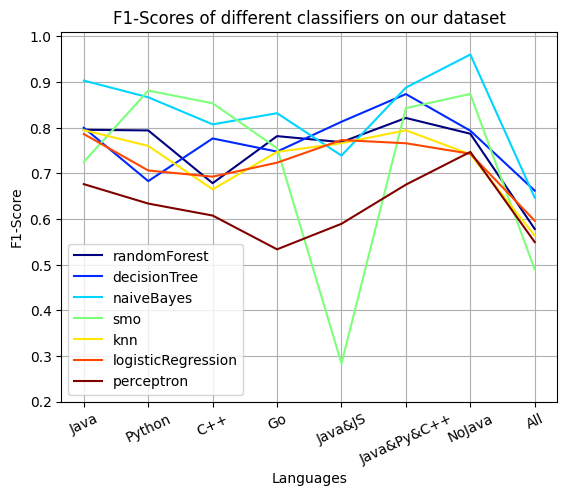

In [145]:
## comment the lines you do not need to generate your expected figure
vis_data = f1scores
# vis_data = accuracys
fig = plt.plot(figsize=(30,30))


plt.xlabel('Languages')
plt.ylabel('F1-Score')
plt.grid()
plt.ylim([0.2, 1.01])
colors = plt.cm.jet(np.linspace(0,1,7))
xticks_labels = ['Java', 'Python', 'C++', 'Go', 'Java&JS', 'Java&Py&C++', 'NoJava', 'All']
xticks(np.linspace(0, 7, 8, endpoint=True), xticks_labels, rotation=25)
plt.plot(xticks_labels, vis_data[0,:], '-', color=colors[0],label=list(classifiers.keys())[0])
plt.plot(xticks_labels, vis_data[1,:], '-', color=colors[1], label=list(classifiers.keys())[1])
plt.plot(xticks_labels, vis_data[2,:], '-', color=colors[2], label=list(classifiers.keys())[2])
plt.plot(xticks_labels, vis_data[3,:], '-', color=colors[3], label=list(classifiers.keys())[3])
plt.plot(xticks_labels, vis_data[4,:], '-', color=colors[4], label=list(classifiers.keys())[4])
plt.plot(xticks_labels, vis_data[5,:], '-', color=colors[5], label=list(classifiers.keys())[5])
plt.plot(xticks_labels, vis_data[6,:], '-', color=colors[6], label=list(classifiers.keys())[6])


plt.title('F1-Scores of different classifiers on our dataset')
plt.legend()
plt.show()